In [57]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular.going_modular import data_setup, engine, predictions

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
%matplotlib inline

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
#Creata seed fucntions
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Загрузка и подготовка данных

In [60]:
image_path = "Dataset\pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

train_dir, test_dir

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1db8ff7ef20>,
 ['pizza', 'steak', 'sushi'])

In [61]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms() 

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1db8ffd1480>,
 ['pizza', 'steak', 'sushi'])

# Загрузка и подготовка модели

In [62]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.features.parameters():
    param.requires_grad = False
    

set_seeds() 

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [63]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

# Тренировка модели

In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str, 
                  model_name: str,
                  log_dir: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
  
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join(log_dir, timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join(log_dir, timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [83]:
writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               log_dir = 'runs',
                               extra="5_epochs")


[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_10_percent\effnetb0\5_epochs...


In [84]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

In [85]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [86]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device,
                writer = writer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5378 | train_acc: 0.9219 | test_loss: 0.5756 | test_acc: 0.8561
Epoch: 2 | train_loss: 0.5359 | train_acc: 0.8086 | test_loss: 0.5469 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5323 | train_acc: 0.8242 | test_loss: 0.4890 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.4640 | train_acc: 0.9258 | test_loss: 0.4863 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4910 | train_acc: 0.7969 | test_loss: 0.5201 | test_acc: 0.8456


In [95]:
writer_10_epoch = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               log_dir = 'runs',
                               extra="10_epochs")

[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_10_percent\effnetb0\10_epochs...


In [96]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device,
                writer = writer_10_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3936 | train_acc: 0.9375 | test_loss: 0.4695 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3985 | train_acc: 0.9531 | test_loss: 0.4535 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.3946 | train_acc: 0.8398 | test_loss: 0.4173 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.3658 | train_acc: 0.9609 | test_loss: 0.4064 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.3644 | train_acc: 0.9492 | test_loss: 0.4371 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.3820 | train_acc: 0.8281 | test_loss: 0.4090 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.3584 | train_acc: 0.9453 | test_loss: 0.3847 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.4091 | train_acc: 0.8281 | test_loss: 0.3964 | test_acc: 0.8561
Epoch: 9 | train_loss: 0.3663 | train_acc: 0.8477 | test_loss: 0.4074 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.2905 | train_acc: 0.9805 | test_loss: 0.3541 | test_acc: 0.8769


# Эксперимент с увеличенным объемом данных

In [102]:
path_20_precent = 'Dataset/pizza_steak_sushi_20'
train_dir_20_percent = path_20_precent + "/train"


# Check the directories
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 20%: Dataset/pizza_steak_sushi_20/train
Testing directory: Dataset\pizza_steak_sushi/test


In [104]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [106]:
BATCH_SIZE = 32

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 20 percent training data: 15
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [111]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Параметры обучения сетей

In [115]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader,
                     "data_20_percent": train_dataloader_20_percent}

In [116]:
from going_modular.going_modular.utils import save_model

In [119]:
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       log_dir = 'runs',
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="Models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0362 | train_acc: 0.4961 | test_loss: 0.8857 | test_acc: 0.5900
Epoch: 2 | train_loss: 0.9294 | train_acc: 0.5625 | test_loss: 0.8320 | test_acc: 0.6013
Epoch: 3 | train_loss: 0.8302 | train_acc: 0.7031 | test_loss: 0.7347 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7197 | train_acc: 0.7773 | test_loss: 0.6203 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.5888 | train_acc: 0.8828 | test_loss: 0.5801 | test_acc: 0.9176
[INFO] Saving model to: Models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0973 | train_acc: 0.3359 | test_loss: 0.9408 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.8952 | train_acc: 0.6523 | test_loss: 0.8661 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.8361 | train_acc: 0.6602 | test_loss: 0.7802 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7213 | train_acc: 0.8477 | test_loss: 0.6765 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.7169 | train_acc: 0.7461 | test_loss: 0.6176 | test_acc: 0.9176
[INFO] Saving model to: Models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0362 | train_acc: 0.4961 | test_loss: 0.8857 | test_acc: 0.5900
Epoch: 2 | train_loss: 0.9294 | train_acc: 0.5625 | test_loss: 0.8320 | test_acc: 0.6013
Epoch: 3 | train_loss: 0.8302 | train_acc: 0.7031 | test_loss: 0.7347 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7197 | train_acc: 0.7773 | test_loss: 0.6203 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.5888 | train_acc: 0.8828 | test_loss: 0.5801 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.5552 | train_acc: 0.8438 | test_loss: 0.6024 | test_acc: 0.8674
Epoch: 7 | train_loss: 0.6131 | train_acc: 0.7617 | test_loss: 0.5953 | test_acc: 0.8163
Epoch: 8 | train_loss: 0.4832 | train_acc: 0.9297 | test_loss: 0.5320 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.4611 | train_acc: 0.9219 | test_loss: 0.5334 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.5444 | train_acc: 0.7734 | test_loss: 0.4888 | test_acc: 0.8561
[INFO] Saving model to: Models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0973 | train_acc: 0.3359 | test_loss: 0.9408 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.8952 | train_acc: 0.6523 | test_loss: 0.8661 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.8361 | train_acc: 0.6602 | test_loss: 0.7802 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7213 | train_acc: 0.8477 | test_loss: 0.6765 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.7169 | train_acc: 0.7461 | test_loss: 0.6176 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.6151 | train_acc: 0.7773 | test_loss: 0.6307 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.5810 | train_acc: 0.8047 | test_loss: 0.5672 | test_acc: 0.9290
Epoch: 8 | train_loss: 0.5401 | train_acc: 0.8242 | test_loss: 0.5475 | test_acc: 0.9186
Epoch: 9 | train_loss: 0.5136 | train_acc: 0.8047 | test_loss: 0.5188 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5023 | train_acc: 0.8203 | test_loss: 0.5267 | test_acc: 0.9186
[INFO] Saving model to: Models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6391 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5559 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5836 | train_acc: 0.8375 | test_loss: 0.4759 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.4559 | train_acc: 0.8938 | test_loss: 0.3966 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8938 | test_loss: 0.3614 | test_acc: 0.9384
[INFO] Saving model to: Models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7603 | test_acc: 0.8258
Epoch: 2 | train_loss: 0.7181 | train_acc: 0.7917 | test_loss: 0.6379 | test_acc: 0.8362
Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5336 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8333 | test_loss: 0.4840 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4168 | test_acc: 0.9593
[INFO] Saving model to: Models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-06-11\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6391 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5559 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5836 | train_acc: 0.8375 | test_loss: 0.4759 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.4559 | train_acc: 0.8938 | test_loss: 0.3966 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8938 | test_loss: 0.3614 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4222 | train_acc: 0.8604 | test_loss: 0.3564 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3849 | train_acc: 0.8583 | test_loss: 0.3165 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3451 | train_acc: 0.8938 | test_loss: 0.3206 | test_acc: 0.9489
Epoch: 9 | train_loss: 0.3723 | train_acc: 0.8917 | test_loss: 0.3152 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3593 | train_acc: 0.8938 | test_loss: 0.2575 | test_acc: 0.9280
[INFO] Saving model to: Models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7603 | test_acc: 0.8258
Epoch: 2 | train_loss: 0.7181 | train_acc: 0.7917 | test_loss: 0.6379 | test_acc: 0.8362
Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5336 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8333 | test_loss: 0.4840 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4168 | test_acc: 0.9593
Epoch: 6 | train_loss: 0.3795 | train_acc: 0.9146 | test_loss: 0.4318 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.3519 | train_acc: 0.9313 | test_loss: 0.3784 | test_acc: 0.9489
Epoch: 8 | train_loss: 0.3214 | train_acc: 0.9333 | test_loss: 0.3765 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3428 | train_acc: 0.8896 | test_loss: 0.3934 | test_acc: 0.8778
Epoch: 10 | train_loss: 0.3791 | train_acc: 0.8604 | test_loss: 0.3348 | test_acc: 0.9593
[INFO] Saving model to: Models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [120]:
#%load_ext tensorboard
%tensorboard --logdir runs 
#taskkill /IM "tensorboard.exe" /F

Reusing TensorBoard on port 6006 (pid 7020), started 1:22:18 ago. (Use '!kill 7020' to kill it.)

# Загрузка лучшей модели

In [122]:
best_model_path = "Models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [123]:
# Размер модели 
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


## Прогнозы модели

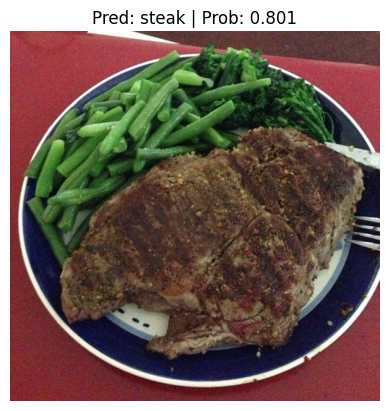

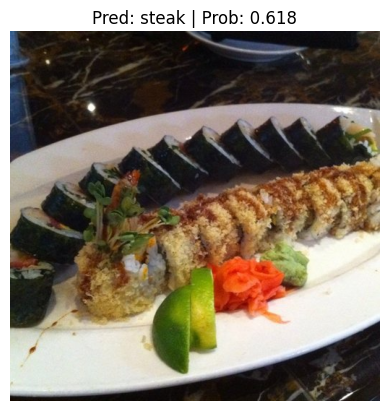

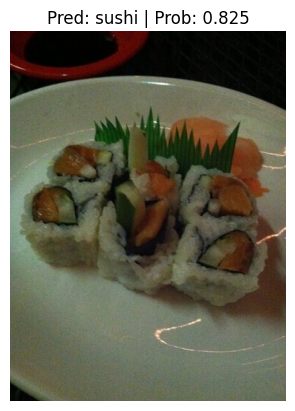

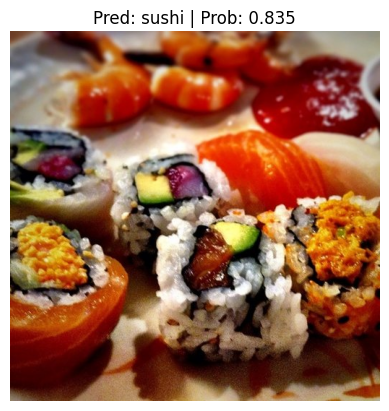

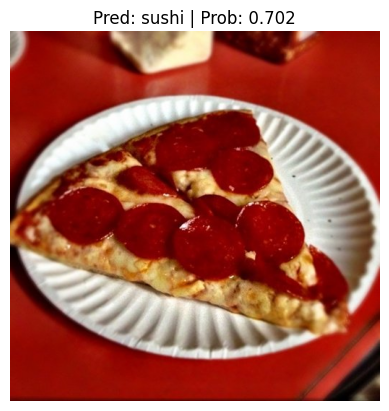

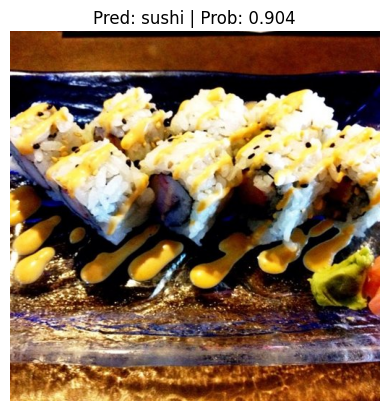

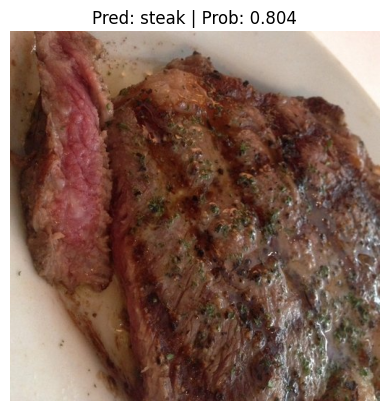

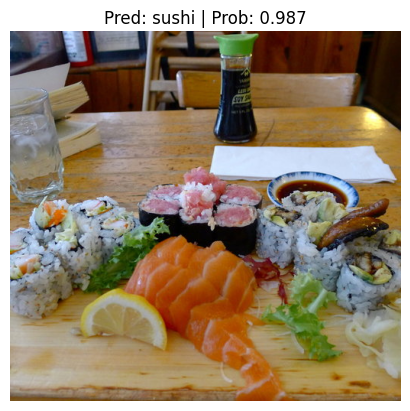

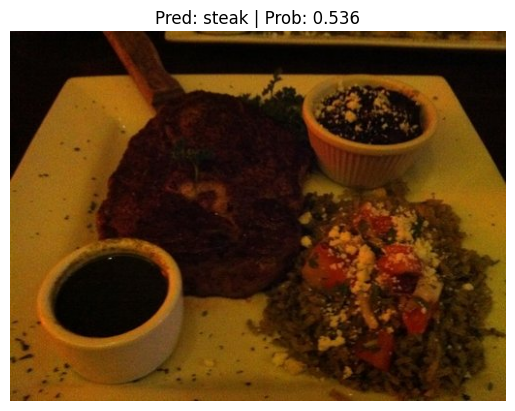

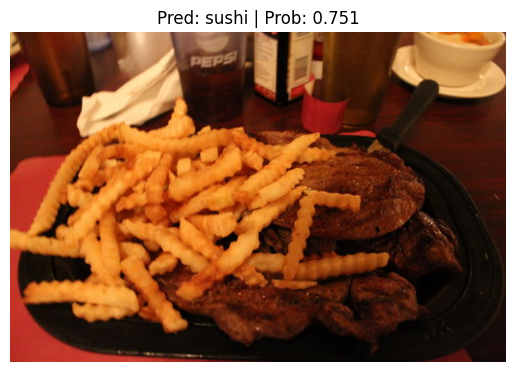

In [129]:
import random
from going_modular.going_modular.predictions import pred_and_plot_image

num_images_to_plot = 10
path_20_precent = 'Dataset/pizza_steak_sushi_20'
test_image_path_list = list(Path(path_20_precent + "/test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

# Матрица ошибок

In [131]:
from tqdm.auto import tqdm
y_preds = []
best_model.eval()
with torch.inference_mode(): # get predict data
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    x = X.unsqueeze(dim=0)
    y_logit = best_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

<Axes: title={'center': 'Confusion Matrix'}>

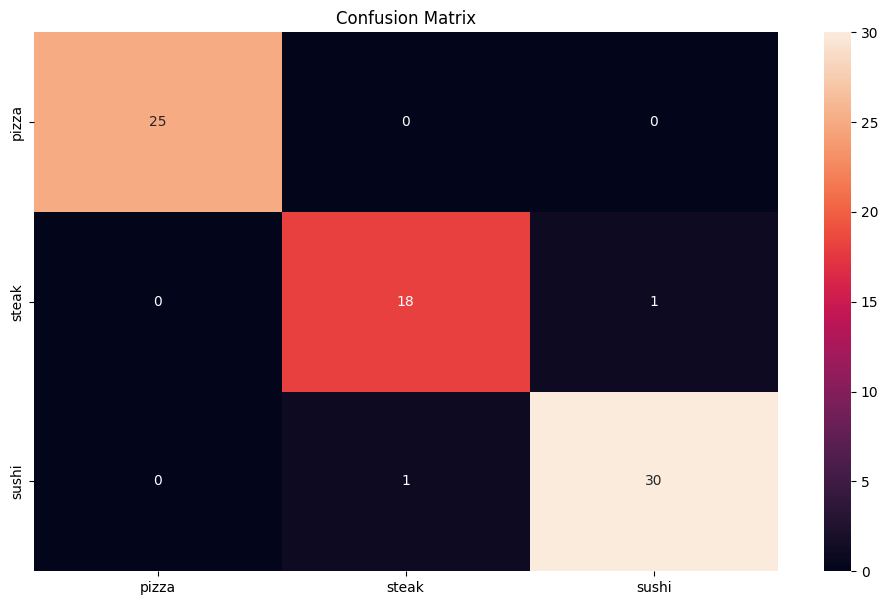

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
normalize = False
# iterate over test data
for inputs, labels in test_dataloader:
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) 

# constant for classes
classes = ('pizza', 'steak', 'sushi')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred_tensor)
if normalize:
    value = cf_matrix/np.sum(cf_matrix)
else:
    value = cf_matrix
    
df_cm = pd.DataFrame(value, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix')
sn.heatmap(df_cm, annot=True)